# Reconstruction of plant--pollinator networks from observational data 

A tutorial on how to use our [Stan](http://mc-stan.org) model to infer the structure and properties of real ecosystems from noisy, error-prone measurements.
Based on the article [*"Reconstruction of plant--pollinator networks from observational data"*](https://www.biorxiv.org/content/10.1101/754077v1), by [J.-G. Young](http://jgyoung.ca), [F. S. Valdovinos](https://www.fsvaldovinos.com/) and [M.E.J. Newman](http://www-personal.umich.edu/~mejn/).


*Authors*: J.-G. Young <jgyou@umich.edu> S. Dritz <sjdritz@ucdavis.edu> <br/>
*Date*: April 2022 <br/>

---

**Important Note:** In this notebook, I assume that you have installed `pystan` and will interact with the model in `python3` (check the [README](README.md) file otherwise). `Stan` also has a [R interface](https://cran.r-project.org/web/packages/rstan/index.html), for which we do not provide helper functions.
That said, all what we show here should easily be transferable to the `R` version of `Stan`!
The only purpose of our python code is to manipulate the samples once they have been generated by `Stan`.

---

## Loading data and modules

First, let's import some required modules: 'pystan `numpy` and `pyplot` to handle the model the data and visualize our results.
We'll also import the custom helper modules `utilities` (load / save / compress / sort data matrices) and `plant_pol_inference` (interact with model, draw samples, compute estimates).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import utilities as ut
import plant_pol_inference_pystan3 as pp
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

We'll use the data matrix shown in the paper as an example. 
It comes from the Supplementary information of [this paper by Kaiser-Bunbury et al. [Nature **542**, 2017]](https://www.nature.com/articles/nature21071). It records the number of interactions between 8 plant species and 21 pollinator species. This is for a single ecosystem, as observed over the course of one month.

In [2]:
M = np.loadtxt('example_matrix.txt').astype('int')
M = ut.sort(M, M)
n_p = M.shape[0]
n_a = M.shape[1]

Let's visualize it:

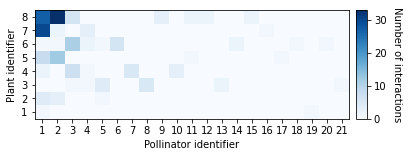

In [3]:
plt.figure(figsize=(6,2))
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');

## Pystan model

In `pystan`, we write the statistical model in a separate file.
In our case, it looks like:

In [4]:
with open('model_pystan3.stan', 'r') as f:
    print(f.read())

data {
  // Dimensions of the data matrix, and matrix itself.
  int<lower=1> n_p;
  int<lower=1> n_a;
  array[n_p, n_a] int<lower=0> M;
}
transformed data {
  // Pre-compute the marginals of M to save computation in the model loop.
  array[n_p] int M_rows = rep_array(0, n_p);
  array[n_a] int M_cols = rep_array(0, n_a);
  int M_tot = 0;
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      M_rows[i] += M[i, j];
      M_cols[j] += M[i, j];
      M_tot += M[i, j];
    }
  }
}
parameters {
  real<lower=0> C;
  real<lower=0> r;
  simplex[n_p] sigma;
  simplex[n_a] tau;
  real<lower=0, upper=1> rho;
}
model {
  // Global sums and parameters
  target += M_tot * log(C) - C;
  // Weighted marginals of the data matrix 
  for (i in 1:n_p) {
    target += M_rows[i] * log(sigma[i]);
  }
  for (j in 1:n_a) {
    target += M_cols[j] * log(tau[j]);
  }
  // Pairwise loop
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      real nu_ij_0 = log(1 - rho);
      real nu_ij_1 = log(rho) + M[i,j] * log(1 + r) - C 

The `data` block contains the model parameters, in our case the dimension of the observation matrix, and the matrix itself.

The `transformed data` block allows us to calculate quantities that we'll use later. Here, we calculate the row and column sums of M, as well as its total sum.

The `parameter` block contains... well.. the parameters of the model.
These parameters are the ones that will be sampled by `Stan`, and returned to us  once we run the program.
`sigma` and `tau` are of the "simplex" type---just a synonym for normalized distributions.

The `model` block calculates the log-posterior of the model. We accumulate this value in the variable `target`.

The `generated quantities` block contains other quantities, functions of the sampled parameters, that will be returned to us once we run the program. In this case, we generate the matrix Q of edge probabilities given the parameters.

---

## Compiling the model

To  start using the model, we first need to "compile" it.
During compilation, `pystan` builds an executable whose purpose is to generate samples from our model, given an input.

Our module `plant_pol_inference` (imported as `pp`) provides utilities to handle this.

In [5]:
model = pp.compile_stan_model(M, random_seed = 1)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/dz/887wb7q155d3pyd6qzhg8hrm0000gn/T/httpstan_4j_g7msh/model_xqidlx7c.stan', line 42, column 6: A
    control flow statement depends on parameter(s): C, r, rho, sigma, tau.


[Compiling]


## Sampling

With the model compiled, we are ready to generate our first samples.

Our `plant_pol_inference` module also provide utilities that handle this.

In [10]:
samples = pp.generate_sample(model, num_warmup=2000, num_samples=500)

Sampling:   0%
Sampling:   0% (1/10000)
Sampling:   1% (100/10000)
Sampling:   2% (200/10000)
Sampling:   3% (300/10000)
Sampling:   4% (400/10000)
Sampling:   5% (500/10000)
Sampling:   6% (600/10000)
Sampling:   7% (700/10000)
Sampling:   8% (800/10000)
Sampling:   9% (900/10000)
Sampling:  10% (1000/10000)
Sampling:  11% (1100/10000)
Sampling:  12% (1200/10000)
Sampling:  13% (1300/10000)
Sampling:  14% (1400/10000)
Sampling:  15% (1500/10000)
Sampling:  16% (1600/10000)
Sampling:  17% (1700/10000)
Sampling:  18% (1800/10000)
Sampling:  19% (1900/10000)
Sampling:  25% (2500/10000)
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 9.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.95 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.94 seconds.
  Adjust your expectations accordingly!
  Gradient evaluatio

We can see by plotting the value of the posterior distribution, evaluated for each samples, that at least one chain has gotten stuck in a minima.

Note that in this plot, vertical lines separate Markov chains: All samples between two of these lines are generated sequentially, by an independent chain.

Text(0, 0.5, 'log posterior')

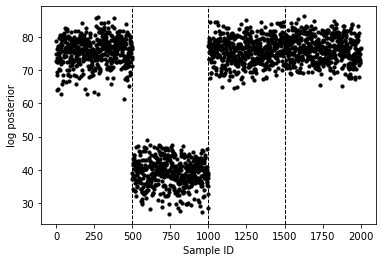

In [7]:
# re-sort data so that it can be easiliy visualized by chain
chains = [1, 2, 3, 4] * 500
log_probs = np.column_stack((chains, samples['lp__'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.scatter(range(2000), log_probs[:,1], s=10, c='k')
for sep in [500, 1000, 1500]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior')

In this particular case, one chain has gotten stuck in an optima with lower posterior probability.

We'll re-run the sampling until we get a clean sample:

In [8]:
while not pp.test_samples(samples, tol=0.05):
    model = pp.compile_stan_model(M)
    samples = pp.generate_sample(model, num_warmup=2000, num_samples=500)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/dz/887wb7q155d3pyd6qzhg8hrm0000gn/T/httpstan_4j_g7msh/model_xqidlx7c.stan', line 42, column 6: A
    control flow statement depends on parameter(s): C, r, rho, sigma, tau.
Sampling:   0%


[Average Log-Probability Per Chain]
[76.6442761  38.5660449  75.23111811 76.35095311]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (301/10000)
Sampling:   5% (501/10000)
Sampling:   7% (700/10000)
Sampling:   9% (900/10000)
Sampling:  11% (1100/10000)
Sampling:  13% (1300/10000)
Sampling:  15% (1500/10000)
Sampling:  18% (1800/10000)
Sampling:  19% (1900/10000)
Sampling:  21% (2100/10000)
Sampling:  22% (2200/10000)
Sampling:  25% (2500/10000)
Sampling:  27% (2700/10000)
Sampling:  30% (3000/10000)
Sampling:  32% (3200/10000)
Sampling:  35% (3500/10000)
Sampling:  37% (3700/10000)
Sampling:  40% (4000/10000)
Sampling:  42% (4200/10000)
Sampling:  45% (4500/10000)
Sampling:  47% (4700/10000)
Sampling:  50% (5000/10000)
Sampling:  51% (5100/10000)
Sampling:  55% (5500/10000)
Sampling:  57% (5700/10000)
Sampling:  66% (6600/10000)
Sampling:  75% (7500/10000)
Sampling:  81% (8100/10000)
Sampling:  94% (9400/10000)
Sampling: 100% (10000/10000)
Sampling:

[Average Log-Probability Per Chain]
[77.09254067 59.48670189 76.11970936 49.66093254]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   3% (302/10000)
Sampling:   6% (601/10000)
Sampling:   7% (700/10000)
Sampling:  10% (1000/10000)
Sampling:  12% (1200/10000)
Sampling:  16% (1600/10000)
Sampling:  18% (1800/10000)
Sampling:  20% (2000/10000)
Sampling:  23% (2300/10000)
Sampling:  27% (2700/10000)
Sampling:  28% (2800/10000)
Sampling:  31% (3100/10000)
Sampling:  34% (3400/10000)
Sampling:  35% (3500/10000)
Sampling:  37% (3700/10000)
Sampling:  39% (3900/10000)
Sampling:  42% (4200/10000)
Sampling:  44% (4400/10000)
Sampling:  47% (4700/10000)
Sampling:  50% (5000/10000)
Sampling:  51% (5100/10000)
Sampling:  54% (5400/10000)
Sampling:  57% (5700/10000)
Sampling:  60% (6000/10000)
Sampling:  76% (7600/10000)
Sampling:  84% (8400/10000)
Sampling:  90% (9000/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluatio

[Average Log-Probability Per Chain]
[ 75.01828323  35.18560194  54.75278711 691.55607543]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (301/10000)
Sampling:   5% (500/10000)
Sampling:   8% (800/10000)
Sampling:  11% (1100/10000)
Sampling:  12% (1200/10000)
Sampling:  15% (1500/10000)
Sampling:  18% (1800/10000)
Sampling:  21% (2100/10000)
Sampling:  22% (2200/10000)
Sampling:  25% (2500/10000)
Sampling:  28% (2800/10000)
Sampling:  31% (3100/10000)
Sampling:  33% (3300/10000)
Sampling:  37% (3700/10000)
Sampling:  41% (4100/10000)
Sampling:  45% (4500/10000)
Sampling:  47% (4700/10000)
Sampling:  50% (5000/10000)
Sampling:  53% (5300/10000)
Sampling:  56% (5600/10000)
Sampling:  58% (5800/10000)
Sampling:  62% (6200/10000)
Sampling:  70% (7000/10000)
Sampling:  78% (7800/10000)
Sampling:  88% (8800/10000)
Sampling:  94% (9400/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation

[Average Log-Probability Per Chain]
[38.86392086 39.29904178 77.53871005 39.54992716]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (301/10000)
Sampling:   6% (601/10000)
Sampling:   8% (800/10000)
Sampling:   9% (900/10000)
Sampling:  10% (1000/10000)
Sampling:  13% (1300/10000)
Sampling:  14% (1400/10000)
Sampling:  15% (1500/10000)
Sampling:  17% (1700/10000)
Sampling:  20% (2000/10000)
Sampling:  22% (2200/10000)
Sampling:  24% (2400/10000)
Sampling:  25% (2500/10000)
Sampling:  28% (2800/10000)
Sampling:  29% (2900/10000)
Sampling:  31% (3100/10000)
Sampling:  33% (3300/10000)
Sampling:  37% (3700/10000)
Sampling:  39% (3900/10000)
Sampling:  41% (4100/10000)
Sampling:  42% (4200/10000)
Sampling:  50% (5000/10000)
Sampling:  55% (5500/10000)
Sampling:  60% (6000/10000)
Sampling:  65% (6500/10000)
Sampling:  66% (6600/10000)
Sampling:  67% (6700/10000)
Sampling:  69% (6900/10000)
Sampling:  71% (7100/10000)
Sampling:  72% (7200/10000)
Sampling: 

[Average Log-Probability Per Chain]
[38.63530514 76.20984757 76.12680198 75.89185475]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   3% (302/10000)
Sampling:   5% (501/10000)
Sampling:   7% (700/10000)
Sampling:   8% (800/10000)
Sampling:  11% (1100/10000)
Sampling:  13% (1300/10000)
Sampling:  14% (1400/10000)
Sampling:  15% (1500/10000)
Sampling:  18% (1800/10000)
Sampling:  19% (1900/10000)
Sampling:  21% (2100/10000)
Sampling:  23% (2300/10000)
Sampling:  26% (2600/10000)
Sampling:  28% (2800/10000)
Sampling:  30% (3000/10000)
Sampling:  31% (3100/10000)
Sampling:  35% (3500/10000)
Sampling:  37% (3700/10000)
Sampling:  39% (3900/10000)
Sampling:  41% (4100/10000)
Sampling:  44% (4400/10000)
Sampling:  45% (4500/10000)
Sampling:  50% (5000/10000)
Sampling:  54% (5400/10000)
Sampling:  61% (6100/10000)
Sampling:  67% (6700/10000)
Sampling:  69% (6900/10000)
Sampling:  71% (7100/10000)
Sampling:  73% (7300/10000)
Sampling:  74% (7400/10000)
Sampling:  75% (7500/10000)
Sampling:

[Average Log-Probability Per Chain]
[76.16254013 76.55028369 76.50393873 37.65337969]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (301/10000)
Sampling:   6% (601/10000)
Sampling:   7% (701/10000)
Sampling:   8% (801/10000)
Sampling:  10% (1000/10000)
Sampling:  13% (1300/10000)
Sampling:  14% (1400/10000)
Sampling:  15% (1500/10000)
Sampling:  16% (1600/10000)
Sampling:  19% (1900/10000)
Sampling:  21% (2100/10000)
Sampling:  23% (2300/10000)
Sampling:  24% (2400/10000)
Sampling:  27% (2700/10000)
Sampling:  29% (2900/10000)
Sampling:  30% (3000/10000)
Sampling:  32% (3200/10000)
Sampling:  36% (3600/10000)
Sampling:  37% (3700/10000)
Sampling:  39% (3900/10000)
Sampling:  41% (4100/10000)
Sampling:  49% (4900/10000)
Sampling:  55% (5500/10000)
Sampling:  60% (6000/10000)
Sampling:  64% (6400/10000)
Sampling:  65% (6500/10000)
Sampling:  66% (6600/10000)
Sampling:  68% (6800/10000)
Sampling:  69% (6900/10000)
Sampling:  70% (7000/10000)
Sampling: 

[Average Log-Probability Per Chain]
[39.84775661 76.42291754 74.99449802 76.14708793]
[Compiling]


Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/dz/887wb7q155d3pyd6qzhg8hrm0000gn/T/httpstan_4j_g7msh/model_xqidlx7c.stan', line 42, column 6: A
    control flow statement depends on parameter(s): C, r, rho, sigma, tau.
Sampling:   0%


[Average Log-Probability Per Chain]
[38.86392086 39.29904178 77.53871005 39.54992716]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   2% (203/10000)
Sampling:   3% (302/10000)
Sampling:   5% (501/10000)
Sampling:   7% (701/10000)
Sampling:   8% (800/10000)
Sampling:   9% (900/10000)
Sampling:  12% (1200/10000)
Sampling:  15% (1500/10000)
Sampling:  17% (1700/10000)
Sampling:  18% (1800/10000)
Sampling:  20% (2000/10000)
Sampling:  23% (2300/10000)
Sampling:  24% (2400/10000)
Sampling:  26% (2600/10000)
Sampling:  29% (2900/10000)
Sampling:  33% (3300/10000)
Sampling:  35% (3500/10000)
Sampling:  37% (3700/10000)
Sampling:  39% (3900/10000)
Sampling:  42% (4200/10000)
Sampling:  44% (4400/10000)
Sampling:  46% (4600/10000)
Sampling:  53% (5300/10000)
Sampling:  61% (6100/10000)
Sampling:  65% (6500/10000)
Sampling:  69% (6900/10000)
Sampling:  75% (7500/10000)
Sampling:  88% (8800/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation 

[Average Log-Probability Per Chain]
[76.6442761  38.5660449  75.23111811 76.35095311]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   4% (401/10000)
Sampling:   5% (500/10000)
Sampling:   7% (700/10000)
Sampling:   9% (900/10000)
Sampling:  12% (1200/10000)
Sampling:  13% (1300/10000)
Sampling:  16% (1600/10000)
Sampling:  18% (1800/10000)
Sampling:  21% (2100/10000)
Sampling:  23% (2300/10000)
Sampling:  26% (2600/10000)
Sampling:  29% (2900/10000)
Sampling:  33% (3300/10000)
Sampling:  34% (3400/10000)
Sampling:  37% (3700/10000)
Sampling:  39% (3900/10000)
Sampling:  42% (4200/10000)
Sampling:  44% (4400/10000)
Sampling:  48% (4800/10000)
Sampling:  51% (5100/10000)
Sampling:  55% (5500/10000)
Sampling:  57% (5700/10000)
Sampling:  66% (6600/10000)
Sampling:  78% (7800/10000)
Sampling:  84% (8400/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 9.4e-05 seconds
  1000 

[Average Log-Probability Per Chain]
[34.94019235 58.84560063 39.06485249 76.61431306]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   2% (203/10000)
Sampling:   3% (302/10000)
Sampling:   4% (401/10000)
Sampling:   6% (600/10000)
Sampling:   9% (900/10000)
Sampling:  10% (1000/10000)
Sampling:  12% (1200/10000)
Sampling:  13% (1300/10000)
Sampling:  16% (1600/10000)
Sampling:  18% (1800/10000)
Sampling:  19% (1900/10000)
Sampling:  21% (2100/10000)
Sampling:  25% (2500/10000)
Sampling:  26% (2600/10000)
Sampling:  28% (2800/10000)
Sampling:  30% (3000/10000)
Sampling:  33% (3300/10000)
Sampling:  35% (3500/10000)
Sampling:  37% (3700/10000)
Sampling:  39% (3900/10000)
Sampling:  43% (4300/10000)
Sampling:  45% (4500/10000)
Sampling:  49% (4900/10000)
Sampling:  54% (5400/10000)
Sampling:  60% (6000/10000)
Sampling:  64% (6400/10000)
Sampling:  65% (6500/10000)
Sampling:  67% (6700/10000)
Sampling:  69% (6900/10000)
Sampling:  71% (7100/10000)
Sampling:  72% (7200/10000)
Sampling:  73% (7300/10000)
Sampling:

[Average Log-Probability Per Chain]
[75.32353082 75.71794388 38.95601909 76.65608877]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (301/10000)
Sampling:   5% (501/10000)
Sampling:   7% (700/10000)
Sampling:   8% (800/10000)
Sampling:  10% (1000/10000)
Sampling:  12% (1200/10000)
Sampling:  13% (1300/10000)
Sampling:  15% (1500/10000)
Sampling:  17% (1700/10000)
Sampling:  20% (2000/10000)
Sampling:  22% (2200/10000)
Sampling:  23% (2300/10000)
Sampling:  25% (2500/10000)
Sampling:  28% (2800/10000)
Sampling:  29% (2900/10000)
Sampling:  31% (3100/10000)
Sampling:  33% (3300/10000)
Sampling:  36% (3600/10000)
Sampling:  38% (3800/10000)
Sampling:  39% (3900/10000)
Sampling:  41% (4100/10000)
Sampling:  44% (4400/10000)
Sampling:  46% (4600/10000)
Sampling:  48% (4800/10000)
Sampling:  50% (5000/10000)
Sampling:  58% (5800/10000)
Sampling:  63% (6300/10000)
Sampling:  68% (6800/10000)
Sampling:  74% (7400/10000)
Sampling:  75% (7500/10000)
Sampling: 

[Average Log-Probability Per Chain]
[75.87753431 49.55043443 76.17156392 77.5642645 ]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (301/10000)
Sampling:   4% (400/10000)
Sampling:   5% (500/10000)
Sampling:   6% (600/10000)
Sampling:   8% (800/10000)
Sampling:  10% (1000/10000)
Sampling:  12% (1200/10000)
Sampling:  13% (1300/10000)
Sampling:  15% (1500/10000)
Sampling:  17% (1700/10000)
Sampling:  19% (1900/10000)
Sampling:  20% (2000/10000)
Sampling:  22% (2200/10000)
Sampling:  24% (2400/10000)
Sampling:  26% (2600/10000)
Sampling:  27% (2700/10000)
Sampling:  29% (2900/10000)
Sampling:  31% (3100/10000)
Sampling:  32% (3200/10000)
Sampling:  34% (3400/10000)
Sampling:  36% (3600/10000)
Sampling:  38% (3800/10000)
Sampling:  40% (4000/10000)
Sampling:  42% (4200/10000)
Sampling:  44% (4400/10000)
Sampling:  45% (4500/10000)
Sampling:  47% (4700/10000)
Sampling:  49% (4900/10000)
Sampling:  51% (5100/10000)
Sampling:  53% (5300/10000)
Sampling:  

[Average Log-Probability Per Chain]
[75.64494353 76.58479011 38.70051632 75.6312271 ]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   4% (401/10000)
Sampling:   6% (600/10000)
Sampling:   7% (700/10000)
Sampling:   9% (900/10000)
Sampling:  11% (1100/10000)
Sampling:  14% (1400/10000)
Sampling:  17% (1700/10000)
Sampling:  19% (1900/10000)
Sampling:  22% (2200/10000)
Sampling:  25% (2500/10000)
Sampling:  27% (2700/10000)
Sampling:  30% (3000/10000)
Sampling:  32% (3200/10000)
Sampling:  35% (3500/10000)
Sampling:  37% (3700/10000)
Sampling:  39% (3900/10000)
Sampling:  42% (4200/10000)
Sampling:  46% (4600/10000)
Sampling:  49% (4900/10000)
Sampling:  52% (5200/10000)
Sampling:  56% (5600/10000)
Sampling:  60% (6000/10000)
Sampling:  63% (6300/10000)
Sampling:  75% (7500/10000)
Sampling:  84% (8400/10000)
Sampling:  90% (9000/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation 

[Average Log-Probability Per Chain]
[58.12833889 58.86417043 54.65507059 39.00361342]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (301/10000)
Sampling:   4% (400/10000)
Sampling:   7% (700/10000)
Sampling:   9% (900/10000)
Sampling:  10% (1000/10000)
Sampling:  12% (1200/10000)
Sampling:  14% (1400/10000)
Sampling:  17% (1700/10000)
Sampling:  18% (1800/10000)
Sampling:  20% (2000/10000)
Sampling:  23% (2300/10000)
Sampling:  25% (2500/10000)
Sampling:  27% (2700/10000)
Sampling:  30% (3000/10000)
Sampling:  34% (3400/10000)
Sampling:  37% (3700/10000)
Sampling:  39% (3900/10000)
Sampling:  41% (4100/10000)
Sampling:  45% (4500/10000)
Sampling:  48% (4800/10000)
Sampling:  50% (5000/10000)
Sampling:  54% (5400/10000)
Sampling:  62% (6200/10000)
Sampling:  73% (7300/10000)
Sampling:  89% (8900/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 9.2e-05 seconds
  1000 

[Average Log-Probability Per Chain]
[38.82488574 49.92767345 76.16583309 57.66348068]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (301/10000)
Sampling:   6% (601/10000)
Sampling:   8% (800/10000)
Sampling:   9% (900/10000)
Sampling:  10% (1000/10000)
Sampling:  13% (1300/10000)
Sampling:  14% (1400/10000)
Sampling:  15% (1500/10000)
Sampling:  17% (1700/10000)
Sampling:  21% (2100/10000)
Sampling:  23% (2300/10000)
Sampling:  25% (2500/10000)
Sampling:  26% (2600/10000)
Sampling:  29% (2900/10000)
Sampling:  31% (3100/10000)
Sampling:  33% (3300/10000)
Sampling:  35% (3500/10000)
Sampling:  39% (3900/10000)
Sampling:  40% (4000/10000)
Sampling:  41% (4100/10000)
Sampling:  43% (4300/10000)
Sampling:  50% (5000/10000)
Sampling:  55% (5500/10000)
Sampling:  60% (6000/10000)
Sampling:  64% (6400/10000)
Sampling:  65% (6500/10000)
Sampling:  66% (6600/10000)
Sampling:  67% (6700/10000)
Sampling:  69% (6900/10000)
Sampling:  70% (7000/10000)
Sampling: 

[Average Log-Probability Per Chain]
[37.33057287 76.4598849  75.61063221 75.70062965]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (301/10000)
Sampling:   5% (500/10000)
Sampling:   7% (700/10000)
Sampling:   8% (800/10000)
Sampling:   9% (900/10000)
Sampling:  10% (1000/10000)
Sampling:  12% (1200/10000)
Sampling:  13% (1300/10000)
Sampling:  15% (1500/10000)
Sampling:  17% (1700/10000)
Sampling:  20% (2000/10000)
Sampling:  22% (2200/10000)
Sampling:  24% (2400/10000)
Sampling:  25% (2500/10000)
Sampling:  28% (2800/10000)
Sampling:  29% (2900/10000)
Sampling:  32% (3200/10000)
Sampling:  34% (3400/10000)
Sampling:  37% (3700/10000)
Sampling:  39% (3900/10000)
Sampling:  41% (4100/10000)
Sampling:  42% (4200/10000)
Sampling:  46% (4600/10000)
Sampling:  48% (4800/10000)
Sampling:  51% (5100/10000)
Sampling:  57% (5700/10000)
Sampling:  64% (6400/10000)
Sampling:  69% (6900/10000)
Sampling:  74% (7400/10000)
Sampling:  84% (8400/10000)
Sampling:  

[Average Log-Probability Per Chain]
[76.25538155 50.61485813 76.26188863 74.97044889]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   3% (303/10000)
Sampling:   4% (402/10000)
Sampling:   6% (601/10000)
Sampling:  10% (1001/10000)
Sampling:  11% (1100/10000)
Sampling:  13% (1300/10000)
Sampling:  15% (1500/10000)
Sampling:  18% (1800/10000)
Sampling:  19% (1900/10000)
Sampling:  21% (2100/10000)
Sampling:  24% (2400/10000)
Sampling:  28% (2800/10000)
Sampling:  30% (3000/10000)
Sampling:  31% (3100/10000)
Sampling:  33% (3300/10000)
Sampling:  38% (3800/10000)
Sampling:  40% (4000/10000)
Sampling:  43% (4300/10000)
Sampling:  48% (4800/10000)
Sampling:  54% (5400/10000)
Sampling:  57% (5700/10000)
Sampling:  59% (5900/10000)
Sampling:  61% (6100/10000)
Sampling:  62% (6200/10000)
Sampling:  64% (6400/10000)
Sampling:  66% (6600/10000)
Sampling:  67% (6700/10000)
Sampling:  68% (6800/10000)
Sampling:  74% (7400/10000)
Sampling:  86% (8600/10000)
Sampling:  92% (9200/10000)
Sampling: 100% (10000/10000)
Sampli

[Average Log-Probability Per Chain]
[ 77.37176984  64.61436455 693.40364413  76.66559421]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   3% (302/10000)
Sampling:   5% (501/10000)
Sampling:   6% (600/10000)
Sampling:   9% (900/10000)
Sampling:  12% (1200/10000)
Sampling:  16% (1600/10000)
Sampling:  17% (1700/10000)
Sampling:  20% (2000/10000)
Sampling:  23% (2300/10000)
Sampling:  27% (2700/10000)
Sampling:  29% (2900/10000)
Sampling:  32% (3200/10000)
Sampling:  35% (3500/10000)
Sampling:  39% (3900/10000)
Sampling:  40% (4000/10000)
Sampling:  44% (4400/10000)
Sampling:  48% (4800/10000)
Sampling:  52% (5200/10000)
Sampling:  54% (5400/10000)
Sampling:  65% (6500/10000)
Sampling:  75% (7500/10000)
Sampling:  82% (8200/10000)
Sampling:  92% (9200/10000)
Sampling:  93% (9300/10000)
Sampling:  94% (9400/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 9.9e-05 seconds
  1000 transitions using 10 leapfr

[Average Log-Probability Per Chain]
[ 54.71860224  39.31927438 692.61733435  76.29229303]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   3% (302/10000)
Sampling:   4% (401/10000)
Sampling:   6% (600/10000)
Sampling:   8% (800/10000)
Sampling:  11% (1100/10000)
Sampling:  13% (1300/10000)
Sampling:  14% (1400/10000)
Sampling:  16% (1600/10000)
Sampling:  19% (1900/10000)
Sampling:  21% (2100/10000)
Sampling:  22% (2200/10000)
Sampling:  25% (2500/10000)
Sampling:  28% (2800/10000)
Sampling:  29% (2900/10000)
Sampling:  31% (3100/10000)
Sampling:  34% (3400/10000)
Sampling:  37% (3700/10000)
Sampling:  39% (3900/10000)
Sampling:  41% (4100/10000)
Sampling:  43% (4300/10000)
Sampling:  47% (4700/10000)
Sampling:  49% (4900/10000)
Sampling:  58% (5800/10000)
Sampling:  70% (7000/10000)
Sampling:  77% (7700/10000)
Sampling:  86% (8600/10000)
Sampling:  87% (8700/10000)
Sampling:  88% (8800/10000)
Sampling:  94% (9400/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.


[Average Log-Probability Per Chain]
[75.92743897 76.0410674  58.49799427 39.33581669]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (302/10000)
Sampling:   4% (401/10000)
Sampling:   5% (501/10000)
Sampling:   7% (700/10000)
Sampling:   9% (900/10000)
Sampling:  11% (1100/10000)
Sampling:  12% (1200/10000)
Sampling:  15% (1500/10000)
Sampling:  16% (1600/10000)
Sampling:  17% (1700/10000)
Sampling:  19% (1900/10000)
Sampling:  21% (2100/10000)
Sampling:  23% (2300/10000)
Sampling:  27% (2700/10000)
Sampling:  29% (2900/10000)
Sampling:  31% (3100/10000)
Sampling:  34% (3400/10000)
Sampling:  36% (3600/10000)
Sampling:  38% (3800/10000)
Sampling:  41% (4100/10000)
Sampling:  47% (4700/10000)
Sampling:  53% (5300/10000)
Sampling:  59% (5900/10000)
Sampling:  61% (6100/10000)
Sampling:  63% (6300/10000)
Sampling:  69% (6900/10000)
Sampling:  76% (7600/10000)
Sampling:  77% (7700/10000)
Sampling:  78% (7800/10000)
Sampling:  79% (7900/10000)
Sampling:  

[Average Log-Probability Per Chain]
[58.88779291 37.56626263 75.77743737 76.68805803]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   3% (303/10000)
Sampling:   5% (502/10000)
Sampling:   7% (701/10000)
Sampling:   9% (900/10000)
Sampling:  10% (1000/10000)
Sampling:  15% (1500/10000)
Sampling:  16% (1600/10000)
Sampling:  17% (1700/10000)
Sampling:  20% (2000/10000)
Sampling:  24% (2400/10000)
Sampling:  26% (2600/10000)
Sampling:  28% (2800/10000)
Sampling:  29% (2900/10000)
Sampling:  33% (3300/10000)
Sampling:  35% (3500/10000)
Sampling:  37% (3700/10000)
Sampling:  38% (3800/10000)
Sampling:  41% (4100/10000)
Sampling:  42% (4200/10000)
Sampling:  44% (4400/10000)
Sampling:  50% (5000/10000)
Sampling:  52% (5201/10000)
Sampling:  56% (5601/10000)
Sampling:  62% (6201/10000)
Sampling:  72% (7201/10000)
Sampling:  73% (7300/10000)
Sampling:  79% (7900/10000)
Sampling:  83% (8300/10000)
Sampling:  84% (8400/10000)
Sampling:  91% (9100/10000)
Sampling:  97% (9700/10000)
Sampling:  99% (9900/10000)
Sampling

[Average Log-Probability Per Chain]
[ 76.22741046  75.68287797 692.19691528 693.93051435]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   4% (401/10000)
Sampling:   6% (600/10000)
Sampling:   8% (800/10000)
Sampling:  11% (1100/10000)
Sampling:  14% (1400/10000)
Sampling:  16% (1600/10000)
Sampling:  18% (1800/10000)
Sampling:  22% (2200/10000)
Sampling:  25% (2500/10000)
Sampling:  27% (2700/10000)
Sampling:  30% (3000/10000)
Sampling:  33% (3300/10000)
Sampling:  36% (3600/10000)
Sampling:  39% (3900/10000)
Sampling:  42% (4200/10000)
Sampling:  46% (4600/10000)
Sampling:  50% (5000/10000)
Sampling:  53% (5300/10000)
Sampling:  56% (5600/10000)
Sampling:  59% (5900/10000)
Sampling:  62% (6200/10000)
Sampling:  75% (7500/10000)
Sampling:  86% (8600/10000)
Sampling:  93% (9300/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 9.4e-05 seconds
  1000 transitions using 10 leapfr

[Average Log-Probability Per Chain]
[76.09129789 58.30639447 39.32327946 38.65007977]
[Compiling]


Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/dz/887wb7q155d3pyd6qzhg8hrm0000gn/T/httpstan_4j_g7msh/model_xqidlx7c.stan', line 42, column 6: A
    control flow statement depends on parameter(s): C, r, rho, sigma, tau.
Sampling:   0%


[Average Log-Probability Per Chain]
[37.33057287 76.4598849  75.61063221 75.70062965]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   4% (401/10000)
Sampling:   5% (501/10000)
Sampling:   6% (601/10000)
Sampling:   8% (800/10000)
Sampling:   9% (900/10000)
Sampling:  12% (1200/10000)
Sampling:  14% (1400/10000)
Sampling:  15% (1500/10000)
Sampling:  17% (1700/10000)
Sampling:  19% (1900/10000)
Sampling:  20% (2000/10000)
Sampling:  22% (2200/10000)
Sampling:  24% (2400/10000)
Sampling:  26% (2600/10000)
Sampling:  28% (2800/10000)
Sampling:  29% (2900/10000)
Sampling:  30% (3000/10000)
Sampling:  33% (3300/10000)
Sampling:  35% (3500/10000)
Sampling:  37% (3700/10000)
Sampling:  39% (3900/10000)
Sampling:  42% (4200/10000)
Sampling:  44% (4400/10000)
Sampling:  46% (4600/10000)
Sampling:  48% (4800/10000)
Sampling:  51% (5100/10000)
Sampling:  53% (5300/10000)
Sampling:  58% (5800/10000)
Sampling:  63% (6300/10000)
Sampling:  70% (7000/10000)
Sampling:  

[Average Log-Probability Per Chain]
[76.63760238 58.18324283 76.64358228 77.12110952]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   3% (302/10000)
Sampling:   4% (401/10000)
Sampling:   6% (600/10000)
Sampling:   8% (800/10000)
Sampling:  12% (1200/10000)
Sampling:  14% (1400/10000)
Sampling:  15% (1500/10000)
Sampling:  18% (1800/10000)
Sampling:  21% (2100/10000)
Sampling:  22% (2200/10000)
Sampling:  24% (2400/10000)
Sampling:  27% (2700/10000)
Sampling:  31% (3100/10000)
Sampling:  33% (3300/10000)
Sampling:  34% (3400/10000)
Sampling:  36% (3600/10000)
Sampling:  41% (4100/10000)
Sampling:  43% (4300/10000)
Sampling:  45% (4500/10000)
Sampling:  52% (5200/10000)
Sampling:  59% (5900/10000)
Sampling:  63% (6300/10000)
Sampling:  70% (7000/10000)
Sampling:  77% (7700/10000)
Sampling:  81% (8100/10000)
Sampling:  82% (8200/10000)
Sampling:  83% (8300/10000)
Sampling:  84% (8400/10000)
Sampling:  85% (8500/10000)
Sampling:  86% (8600/10000)
Sampling:  87% (8700/10000)
Sampling:

[Average Log-Probability Per Chain]
[ 75.78019953  75.5373277   49.85109483 692.9281909 ]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   3% (302/10000)
Sampling:   4% (401/10000)
Sampling:   6% (600/10000)
Sampling:   8% (800/10000)
Sampling:  10% (1000/10000)
Sampling:  11% (1100/10000)
Sampling:  12% (1200/10000)
Sampling:  14% (1400/10000)
Sampling:  17% (1700/10000)
Sampling:  19% (1900/10000)
Sampling:  21% (2100/10000)
Sampling:  23% (2300/10000)
Sampling:  27% (2700/10000)
Sampling:  29% (2900/10000)
Sampling:  30% (3000/10000)
Sampling:  32% (3200/10000)
Sampling:  35% (3500/10000)
Sampling:  37% (3700/10000)
Sampling:  39% (3900/10000)
Sampling:  40% (4000/10000)
Sampling:  44% (4400/10000)
Sampling:  45% (4500/10000)
Sampling:  47% (4700/10000)
Sampling:  52% (5200/10000)
Sampling:  59% (5900/10000)
Sampling:  65% (6500/10000)
Sampling:  70% (7000/10000)
Sampling:  71% (7100/10000)
Sampling:  72% (7200/10000)
Sampling:  73% (7300/10000)
Sampling:  74% (7400/10000)
Sampling:

[Average Log-Probability Per Chain]
[76.17738788 76.27992608 76.09929397 38.06302243]
[Compiling]


Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/dz/887wb7q155d3pyd6qzhg8hrm0000gn/T/httpstan_4j_g7msh/model_xqidlx7c.stan', line 42, column 6: A
    control flow statement depends on parameter(s): C, r, rho, sigma, tau.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 9.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.97 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.94 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.94 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.94 seconds.
  Adjust your expectations accordingly!


[Average Log-Probability Per Chain]
[39.84775661 76.42291754 74.99449802 76.14708793]
[Compiling]


Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/dz/887wb7q155d3pyd6qzhg8hrm0000gn/T/httpstan_4j_g7msh/model_xqidlx7c.stan', line 42, column 6: A
    control flow statement depends on parameter(s): C, r, rho, sigma, tau.
Sampling:   0%


[Average Log-Probability Per Chain]
[75.87753431 49.55043443 76.17156392 77.5642645 ]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   4% (401/10000)
Sampling:   6% (600/10000)
Sampling:   8% (800/10000)
Sampling:   9% (900/10000)
Sampling:  11% (1100/10000)
Sampling:  12% (1200/10000)
Sampling:  14% (1400/10000)
Sampling:  15% (1500/10000)
Sampling:  19% (1900/10000)
Sampling:  20% (2000/10000)
Sampling:  23% (2300/10000)
Sampling:  25% (2500/10000)
Sampling:  28% (2800/10000)
Sampling:  30% (3000/10000)
Sampling:  32% (3200/10000)
Sampling:  34% (3400/10000)
Sampling:  37% (3700/10000)
Sampling:  39% (3900/10000)
Sampling:  42% (4200/10000)
Sampling:  43% (4300/10000)
Sampling:  47% (4700/10000)
Sampling:  49% (4900/10000)
Sampling:  61% (6100/10000)
Sampling:  70% (7000/10000)
Sampling:  77% (7700/10000)
Sampling:  86% (8600/10000)
Sampling:  87% (8700/10000)
Sampling:  93% (9300/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
M

[Average Log-Probability Per Chain]
[76.49761888 58.72723304 76.27429444 37.8004719 ]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (301/10000)
Sampling:   5% (500/10000)
Sampling:   7% (700/10000)
Sampling:   9% (900/10000)
Sampling:  10% (1000/10000)
Sampling:  11% (1100/10000)
Sampling:  14% (1400/10000)
Sampling:  16% (1600/10000)
Sampling:  18% (1800/10000)
Sampling:  19% (1900/10000)
Sampling:  22% (2200/10000)
Sampling:  25% (2500/10000)
Sampling:  27% (2700/10000)
Sampling:  29% (2900/10000)
Sampling:  32% (3200/10000)
Sampling:  34% (3400/10000)
Sampling:  36% (3600/10000)
Sampling:  38% (3800/10000)
Sampling:  41% (4100/10000)
Sampling:  44% (4400/10000)
Sampling:  47% (4700/10000)
Sampling:  48% (4800/10000)
Sampling:  52% (5200/10000)
Sampling:  55% (5500/10000)
Sampling:  69% (6900/10000)
Sampling:  85% (8500/10000)
Sampling:  91% (9100/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during samp

[Average Log-Probability Per Chain]
[76.32675109 54.61501308 57.85216291 63.29811009]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   3% (303/10000)
Sampling:   4% (402/10000)
Sampling:   6% (601/10000)
Sampling:   7% (700/10000)
Sampling:  10% (1000/10000)
Sampling:  12% (1200/10000)
Sampling:  13% (1300/10000)
Sampling:  15% (1500/10000)
Sampling:  18% (1800/10000)
Sampling:  19% (1900/10000)
Sampling:  21% (2100/10000)
Sampling:  22% (2200/10000)
Sampling:  25% (2500/10000)
Sampling:  27% (2700/10000)
Sampling:  28% (2800/10000)
Sampling:  30% (3000/10000)
Sampling:  34% (3400/10000)
Sampling:  36% (3600/10000)
Sampling:  38% (3800/10000)
Sampling:  40% (4000/10000)
Sampling:  43% (4300/10000)
Sampling:  44% (4400/10000)
Sampling:  49% (4900/10000)
Sampling:  53% (5300/10000)
Sampling:  59% (5900/10000)
Sampling:  64% (6400/10000)
Sampling:  65% (6500/10000)
Sampling:  67% (6700/10000)
Sampling:  68% (6800/10000)
Sampling:  69% (6900/10000)
Sampling:  70% (7000/10000)
Sampling:

[Average Log-Probability Per Chain]
[39.3751914  76.28418323 76.04973055 75.44443514]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   4% (401/10000)
Sampling:   6% (601/10000)
Sampling:   7% (700/10000)
Sampling:   8% (800/10000)
Sampling:  10% (1000/10000)
Sampling:  12% (1200/10000)
Sampling:  14% (1400/10000)
Sampling:  15% (1500/10000)


TypeError: 'NoneType' object is not subscriptable

After a few attempts we find a nice set of samples:

Text(0, 0.5, 'log posterior')

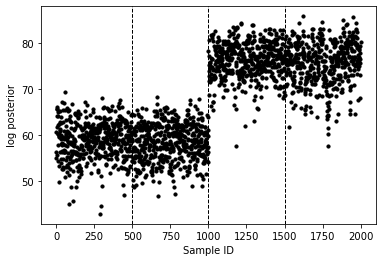

In [12]:
# re-sort data so that it can be easiliy visualized by chain
chains = [1, 2, 3, 4] * 500
log_probs = np.column_stack((chains, samples['lp__'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.scatter(range(2000), log_probs[:,1], s=10, c='k')
for sep in [500, 1000, 1500]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior')

Here's the summary of our succesful sampling procedure:

In [13]:
samples.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,C,r,sigma.1,...,Q.7.20,Q.8.20,Q.1.21,Q.2.21,Q.3.21,Q.4.21,Q.5.21,Q.6.21,Q.7.21,Q.8.21
draws,,,,,,,,,,,,,,,,,,,,,
0,55.007329,0.986831,0.230707,4.0,15.0,0.0,-41.275396,72.845136,22.887899,0.002667,...,1.681437e-01,3.508478e-02,0.184714,0.148900,0.781917,0.145571,0.096706,0.144171,0.159292,1.408622e-02
1,56.931238,0.913119,0.195151,4.0,15.0,0.0,-45.216062,70.007020,22.653659,0.017722,...,9.835504e-02,2.161871e-08,0.203131,0.149200,0.715186,0.143177,0.015938,0.146464,0.174840,5.610543e-04
2,73.920206,0.784142,0.131042,5.0,31.0,0.0,-56.770110,13.111404,72.302011,0.003351,...,1.981421e-01,2.005876e-01,0.259158,0.242862,0.954407,0.151160,0.230017,0.132683,0.151511,1.553022e-01
3,77.119214,0.985057,0.123719,5.0,31.0,0.0,-66.584889,15.173742,60.312544,0.014501,...,2.618983e-12,2.493725e-12,0.252939,0.255587,0.928415,0.057942,0.183695,0.059448,0.072876,7.267288e-02
4,58.542497,0.883512,0.230707,4.0,15.0,0.0,-37.853665,66.611909,28.146766,0.005258,...,1.698971e-02,4.738284e-14,0.090329,0.002781,0.144257,0.002116,0.000009,0.000404,0.016529,3.206661e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,79.088962,0.947717,0.123719,5.0,31.0,0.0,-61.391498,12.387590,62.495938,0.077972,...,1.154974e-01,1.207686e-01,0.142674,0.217084,0.631867,0.092730,0.185112,0.041252,0.076094,8.128899e-02
1996,58.024935,0.998597,0.230707,4.0,15.0,0.0,-41.184588,83.498588,32.298491,0.003846,...,1.068970e-01,1.929212e-03,0.120837,0.051720,0.655175,0.089382,0.036512,0.080885,0.105039,1.186531e-03
1997,55.973661,0.864536,0.195151,4.0,15.0,0.0,-43.412591,70.244300,24.540885,0.005797,...,1.259888e-01,4.153705e-03,0.135323,0.030621,0.540698,0.032623,0.003492,0.010126,0.065652,5.800048e-08


We now have well-behaved samples, let's move on to model checking and estimation.

## Posterior-predictive check

We provide a simple function that calculates the posterior predictive matrix.

In [14]:
M_tilde = pp.get_posterior_predictive_matrix(samples)

Let's compare it with the input

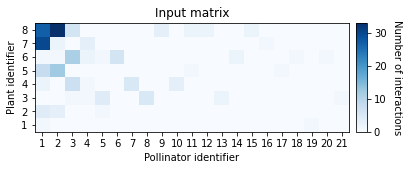

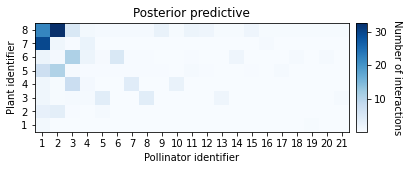

In [15]:
plt.figure(figsize=(6,2))
plt.title('Input matrix')
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');
plt.figure(figsize=(6,2))
plt.title('Posterior predictive')
plt.pcolormesh(M_tilde, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');


They are quite close!

More systematically we can check the distribution of the differences between the posterior predictive and the input:

Text(0, 0.5, 'Count')

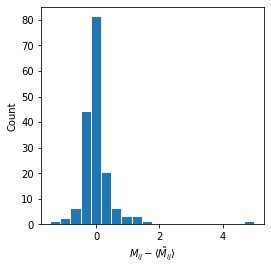

In [16]:
plt.figure(figsize=(4,4))
plt.hist((M-M_tilde).flatten(), density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$M_{ij}-\langle \tilde{M}_{ij}\rangle$')
plt.ylabel('Count')

Or compare the posterior predictive value to the input directly:

(-4.9, 38.0)

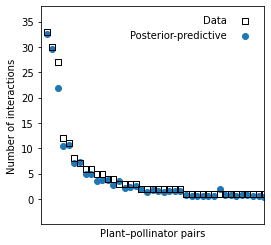

In [17]:
plt.figure(figsize=(4,4))
sort_order = np.argsort(-M.flatten())

plt.scatter(range(1, len(sort_order)+1), M.flatten()[sort_order], marker='s', facecolors='none', edgecolors='k', label='Data')
plt.scatter(range(1, len(sort_order)+1), M_tilde.flatten()[sort_order], label='Posterior-predictive', zorder=-10)

plt.xlim(0,40)
plt.xlabel('Plant–pollinator pairs')
plt.xticks([])
plt.ylabel(r'Number of interactions')
plt.legend(frameon=False, markerfirst=False, loc=1)
plt.ylim(-4.9,38)

All these point of view confirm one thing: The model fits well.

Which means we're ready to calculate some estimates.

## Estimates

We provide a simple function to get the network estimate:

In [18]:
edge_prob = pp.estimate_network(samples)

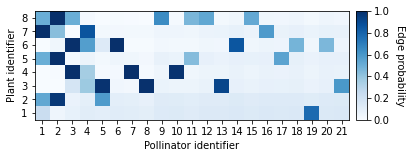

In [19]:
plt.figure(figsize=(6,2))

plt.pcolormesh(edge_prob, cmap=plt.cm.Blues, vmin=0, vmax=1)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Edge probability', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');


The parameters themselves are contained in the `samples` object:

In [31]:
samples['rho']

array([[0.18675187, 0.242861  , 0.26132265, ..., 0.1552987 , 0.16433903,
        0.27344798]])

So we can, for example, visualize posterior distributions as:

Text(0, 0.5, 'Count')

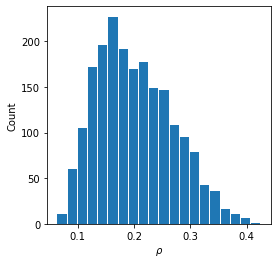

In [32]:
plt.figure(figsize=(4,4))
plt.hist(samples['rho'][0], density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$\rho$')
plt.ylabel('Count')

And find posterior averages with:

In [33]:
print('Posterior average of the connectance:', np.mean(samples['rho'][0], axis=0))

Posterior average of the connectance: 0.2021728436389057


The same thing goes for, say, the plant abundances (now a dimension `n_p * samples` object---hence why we average along the axis 1, the `samples` axis):

In [34]:
mean_sigma = np.mean(samples['sigma'], axis=1)

Text(0, 0.5, 'Effective abundance')

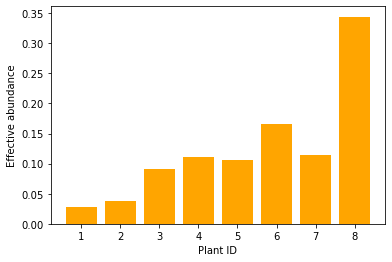

In [35]:
plt.bar([i + 1 for i in range(n_p)], mean_sigma, color='orange')
plt.xlabel('Plant ID')
plt.ylabel('Effective abundance')

We can do the same with the pollinators:

In [36]:
mean_tau = np.mean(samples['tau'], axis=1)

Text(0, 0.5, 'Effective abundance')

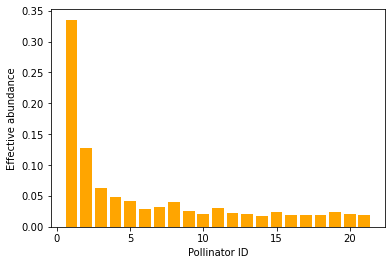

In [37]:
plt.bar([i + 1 for i in range(n_a)], mean_tau, color='orange')
plt.xlabel('Pollinator ID')
plt.ylabel('Effective abundance')

The last thing we'll calculate is the posterior distribution of **some arbitrary function** of the incidence matrix.

To make this example simple, we'll consider the number of non-zero entries, i.e.,

$$f(B) = \sum_{ij} B_{ij}$$

The python definition of this function is simple:

In [38]:
def edge_sum(B):
    return np.sum(B)

Again, we provide a simpler interface to make the calculation:

In [39]:
posterior_values_edge_sum = pp.get_network_property_distribution(samples, edge_sum)

We find, in this case:

Text(0, 0.5, 'Count')

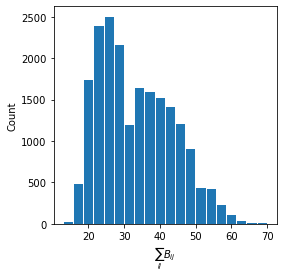

In [40]:
plt.figure(figsize=(4,4))
plt.hist(posterior_values_edge_sum, density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$\sum_{ij} B_{ij}$')
plt.ylabel('Count')

# Further information: 

"*[Reconstruction of plant–pollinator networks from observational data](https://www.biorxiv.org/content/10.1101/754077v1)*"<br/>
[J.-G. Young](http://jgyoung.ca), [F. S. Valdovinos](https://www.fsvaldovinos.com/) and [M.E.J. Newman](http://www-personal.umich.edu/~mejn/)<br/>
bioRxiv:754077 (2019)


Or get in touch at <jgyou@umich.edu> and on [github](https://github.com/jg-you/plant-pol-inference)!